# Chapter 3: Modern Neural Networks - Regularization

In this final notebook for Chapter 3, we demonstrate the effects of the various regularization methods we presented on our simple use-case.

In [50]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

## Preparing the Data

Once again, we prepare the [MNIST](http://yann.lecun.com/exdb/mnist) data:

In [51]:
num_classes = 10
img_rows, img_cols, img_ch = 28, 28, 1
input_shape = (img_rows, img_cols, img_ch)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(x_train.shape[0], *input_shape)
x_test = x_test.reshape(x_test.shape[0], *input_shape)

However this time, to highlight the advantages of regularization, we will make the recognition task harder by artificially reducing the number of samples available for training:

In [62]:
x_train, y_train = x_train[:200], y_train[:200] # ... 200 training samples instead of 60,000...

## Preparing the Model

We also reuse the LeNet-5 model we previously implemented. However, we wrap its instantiation into a function, so that we can spawn multiple ones:

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

In [54]:
def lenet(name='lenet', use_dropout=False, use_batchnorm=False, regularizer=None):
    
    layers = []
    
    # 1st block:
    layers += [Conv2D(6, kernel_size=(5, 5), padding='same', 
                      input_shape=input_shape, kernel_regularizer=regularizer)]
    if use_batchnorm:
        layers += [BatchNormalization()]
    layers += [Activation('relu'),
               MaxPooling2D(pool_size=(2, 2))]
    if use_dropout:
        layers += [Dropout(0.25)]
        
    # 2nd block:
    layers += [ 
        Conv2D(16, kernel_size=(5, 5), kernel_regularizer=regularizer)]
    if use_batchnorm:
        layers += [BatchNormalization()]
    layers += [Activation('relu'),
               MaxPooling2D(pool_size=(2, 2))]
    if use_dropout:
        layers += [Dropout(0.25)]
 
    # Dense layers:
    layers += [Flatten()]
    
    layers += [Dense(120, kernel_regularizer=regularizer)]
    if use_batchnorm:
        layers += [BatchNormalization()]
    layers += [Activation('relu')]
    if use_dropout:
        layers += [Dropout(0.25)]
        
    layers += [Dense(84, kernel_regularizer=regularizer)]
    layers += [Activation('relu')]
        
    layers += [Dense(num_classes, activation='softmax')]
    
    model = Sequential(layers, name=name)
    return model

## Training with Various Regularization Methods


To showcase the effect that modern optimizers (available in Tensorflow and Keras) have on trainings, we will create several similar LeNet instance, and train each with a different optimizer.

First, we instantiate the various optimizers we want to apply:

In [55]:
configurations = {
    'none':         {'use_dropout': False, 'use_batchnorm': False, 'regularizer': None},
    'l1':           {'use_dropout': False, 'use_batchnorm': False, 'regularizer': tf.keras.regularizers.l1(0.01)},
    'l2':           {'use_dropout': False, 'use_batchnorm': False, 'regularizer': tf.keras.regularizers.l2(0.01)},
    'dropout':      {'use_dropout': True,  'use_batchnorm': False, 'regularizer': None},
    'bn':           {'use_dropout': False, 'use_batchnorm': True,  'regularizer': None},
    'l1+dropout':   {'use_dropout': False, 'use_batchnorm': True,  'regularizer': tf.keras.regularizers.l1(0.01)},
    'l1+bn':        {'use_dropout': False, 'use_batchnorm': True,  'regularizer': tf.keras.regularizers.l1(0.01)},
    'l1+dropout+bn':{'use_dropout': False, 'use_batchnorm': True,  'regularizer': tf.keras.regularizers.l1(0.01)}
    # ...
}

For each optimizer we are considering, we will instantiate a new LeNet model and train it with. We will save their training `history` (containing the losses and metrics history over training), for comparison *(this process takes time, especially on CPU!)*:

In [59]:
history_per_instance = dict()

for config_name in configurations:
    # Resetting the seeds (for random number generation), to reduce the impact of randomness on the comparison:
    tf.set_random_seed(42)
    np.random.seed(42)
    # Creating the model:
    model = lenet("lenet_{}".format(config_name))
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # Launching the training (we set `verbose=0`, so the training won't generate any logs):
    history = model.fit(x_train, y_train,
                        batch_size=32, epochs=30, validation_data=(x_test, y_test),
                        verbose=0)
    history_per_instance[config_name] = history
    print('> Training with reg {}: done.'.format(config_name))

> Training with reg none: done.
> Training with reg l1: done.
> Training with reg l2: done.
> Training with reg dropout: done.
> Training with reg bn: done.
> Training with reg l1+dropout: done.
> Training with reg l1+bn: done.
> Training with reg l1+dropout+bn: done.


We finally plot the training and validation losses + accuracies, for comparison:

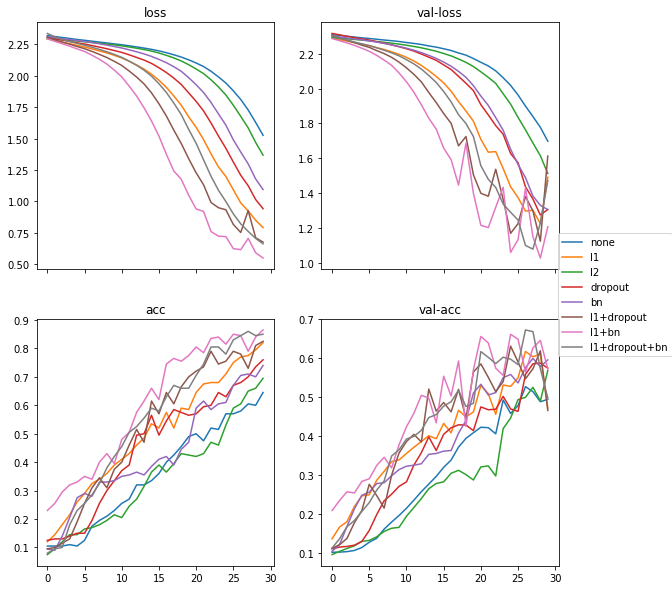

In [60]:
fig, ax = plt.subplots(2, 2, figsize=(10,10), sharex='col') # add parameter `sharey='row'` for a more direct comparison
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("acc")
ax[1, 1].set_title("val-acc")

lines, labels = [], []
for config_name in history_per_instance:
    history = history_per_instance[config_name]
    ax[0, 0].plot(history.history['loss'])
    ax[0, 1].plot(history.history['val_loss'])
    ax[1, 0].plot(history.history['acc'])
    line = ax[1, 1].plot(history.history['val_acc'])
    lines.append(line[0])
    labels.append(config_name)

fig.legend(lines,labels, loc='center right', borderaxespad=0.1)
plt.subplots_adjust(right=0.85)

In [61]:
for config_name in history_per_instance:
    best_val_acc = max(history_per_instance[config_name].history['val_acc']) * 100
    print('Max val-acc for model "{}": {:2.2f}%'.format(config_name, best_val_acc))


Max val-acc for model "none": 52.63%
Max val-acc for model "l1": 61.63%
Max val-acc for model "l2": 56.77%
Max val-acc for model "dropout": 58.67%
Max val-acc for model "bn": 59.85%
Max val-acc for model "l1+dropout": 63.01%
Max val-acc for model "l1+bn": 66.04%
Max val-acc for model "l1+dropout+bn": 67.15%


Given how small and artificial this problem is, the idea is not to directly compare the performance of these regularization techniques, but rather to demonstrate their overall benefits. It is wise to keep these methods in mind when tackling real-life computer vision problems, where data scarcity and overfitting are common problems.
